In [75]:
import torch
from PIL import Image


In [5]:
import pandas as pd
import os


train_labels = pd.read_csv("data/train_labels.csv")
baseline_helmets = pd.read_csv("data/train_baseline_helmets.csv")
train_player_tracking =pd.read_csv("data/train_player_tracking.csv")

In [49]:
train_player_tracking[['x_position', 'y_position', 'speed', 'direction', 'orientation', 'acceleration', 'sa']]

,x_position,y_position,speed,direction,orientation,acceleration,sa
0,61.59,42.60,1.11,320.33,263.93,0.71,-0.64
1,59.48,26.81,0.23,346.84,247.16,1.29,0.90
2,72.19,31.46,0.61,11.77,247.69,0.63,-0.33
3,57.37,22.12,0.37,127.85,63.63,0.69,0.62
4,63.25,27.50,0.51,183.62,253.71,0.31,0.31
...,...,...,...,...,...,...,...
1353048,72.28,51.80,1.59,345.36,342.68,0.49,-0.41
1353049,74.76,54.50,0.98,342.39,354.46,0.63,-0.24
1353050,74.54,55.75,1.12,352.79,349.20,0.63,0.46
1353051,80.44,48.77,1.93,340.78,346.51,0.53,-0.51


In [2]:
train_player_tracking.head()

,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa
0,58580_001136,58580,1136,44830,2021-10-10T21:08:20.900Z,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64
1,58580_001136,58580,1136,47800,2021-10-10T21:08:20.900Z,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90
2,58580_001136,58580,1136,52444,2021-10-10T21:08:20.900Z,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33
3,58580_001136,58580,1136,46206,2021-10-10T21:08:20.900Z,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62
4,58580_001136,58580,1136,52663,2021-10-10T21:08:20.900Z,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31


In [6]:
baseline_helmets.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [54]:
train_labels["frame"] =train_labels["step"]/10*59.95+5*59.95  
train_player_tracking["frame"] =train_player_tracking["step"]/10*59.95+5*59.95  
train_player_tracking["frame"] = train_player_tracking["frame"].astype(int) 

train_labels["frame"] = train_labels["frame"].astype(int) 
train_labels[train_labels['contact']==1].head()

,contact_id,game_play,datetime,step,nfl_player_id_1,nfl_player_id_2,contact,frame
809,58168_003392_3_41944_42565,58168_003392,2020-09-11T03:01:48.400Z,3,41944,42565,1,317
1062,58168_003392_4_41944_42565,58168_003392,2020-09-11T03:01:48.500Z,4,41944,42565,1,323
1163,58168_003392_4_37084_38567,58168_003392,2020-09-11T03:01:48.500Z,4,37084,38567,1,323
1289,58168_003392_5_43854_46445,58168_003392,2020-09-11T03:01:48.600Z,5,43854,46445,1,329
1315,58168_003392_5_41944_42565,58168_003392,2020-09-11T03:01:48.600Z,5,41944,42565,1,329


player1_id 52472 player2_id G
frame  761
58506_001241_Sideline.mp4_0761.jpg


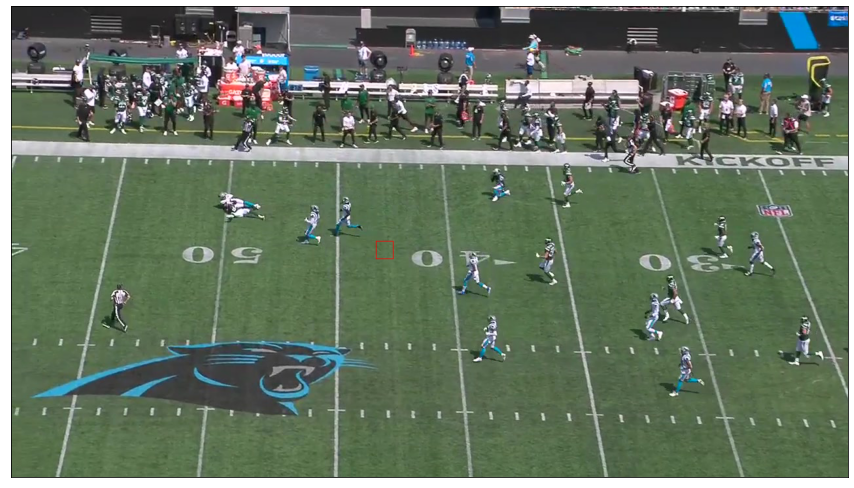

In [39]:
import random
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from torchvision.io import read_image
view = "Sideline"
# idx = random.randint(0, train_labels.shape[0])
# label_record = train_labels.iloc[idx]

positive_labels = train_labels[train_labels['contact']==1]

idx = random.randint(0, positive_labels.shape[0])
label_record = positive_labels.iloc[idx]

player1_id = int(label_record["nfl_player_id_1"])
player2_id = label_record["nfl_player_id_2"]
if player2_id != "G":
    player2_id= int(player2_id)
print("player1_id", player1_id, "player2_id", player2_id)
game_play = label_record['game_play']
frame = int(label_record['frame'])
print("frame ", frame)

player1_record = baseline_helmets[(baseline_helmets['game_play']==game_play)&
(baseline_helmets['nfl_player_id']==player1_id)&(baseline_helmets['frame']==frame)].iloc[0]
# print(player1_record)
ymin1 = player1_record["top"]
xmin1 = player1_record["left"]
height1 = player1_record["height"]
width1 = player1_record["width"]

xmax1 = xmin1+width1
ymax1 = ymin1+height1
if player2_id != "G":
    player2_record = baseline_helmets[(baseline_helmets['game_play']==game_play)&
    (baseline_helmets['nfl_player_id']==player2_id)&(baseline_helmets['frame']==frame)].iloc[0]
    # print(player2_record)
    ymin2 = player2_record["top"]
    xmin2 = player2_record["left"]
    height2 = player2_record["height"]
    width2 = player2_record["width"]

    xmax2 = xmin2+width2
    ymax2 = ymin2+height2
else:
    xmin2,ymin2,xmax2,ymax2 = 0,0,0,0


file_name = game_play+"_" + view +".mp4_{:04d}.jpg".format(frame)
print(file_name)
# file_name ="58579_003527_Sideline.mp4_0775.jpg"
# file_name ="58168_003392_Endzone.mp4_0329.jpg"
image = read_image("data/extracted-train-frames/content/work/frames/train/"+file_name)
boxes = torch.tensor([[xmin1,ymin1,xmax1,ymax1],[xmin2,ymin2,xmax2,ymax2]])



def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

drawn_boxes = draw_bounding_boxes(image, boxes, colors="red")
show(drawn_boxes)


In [24]:
import torchvision

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
class NFLDataset(torch.utils.data.Dataset):
    def __init__(self,labels, helmets, tracking,transforms):
        self.labels = labels
        self.helmets = helmets
        self.tracking = tracking


        self.transforms = transforms

    def __getitem__(self, idx):
        views = 'Endzone', 'Sideline'
        label_record = train_labels.iloc[idx]
        label = label_record['contact']
        game_play = label_record['game_play']
        frame = int(label_record['frame'])
        # boxes =[]
        features =[]
        for player in [1,2]:

            player_id = label_record[f"nfl_player_id_{player}"]
            if player_id!="G":
                player_id = int(player_id)


                player_helmet_record = self.helmets[(self.helmets['game_play']==game_play)&
                (baseline_helmets['nfl_player_id']==player_id)&(baseline_helmets['frame']==frame)]
                player_tracking_record = self.tracking[(self.tracking['game_play']==game_play)&
                (self.tracking['nfl_player_id']==player_id)&(self.tracking['frame']==frame)]
                feature = np.concatenate([player_tracking_record[['x_position', 'y_position', 'speed', 'direction', 'orientation', 'acceleration', 'sa']].values[0], player_helmet_record[["top", "left", "height", "width"]].values[0]])

                features.append(feature)
            else:
                features.append([0,0,0,0,0,0,0,0,0,0,0])

        images =[]
        for view in views:
            file_name = game_play+"_" + view +".mp4_{:04d}.jpg".format(frame)
            image = read_image("data/extracted-train-frames/content/work/frames/train/"+file_name)
            images.append(image)
        # image = torch.stack([image.float(),image.float(),image.float()])
        # image_ft = self.ft_extractor(image)
        # images = torch.tensor(images)
        features = torch.tensor(features)
        return images,features, torch.tensor(label)

    def __len__(self):
        return len(self.labels)



In [66]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ft_extractor = torchvision.models.resnet18(pretrained=True)
        for param in self.ft_extractor.parameters():
            param.requires_grad = False
        num_ftrs = self.ft_extractor.fc.in_features
        self.ft_extractor.fc = Identity()
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),

        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y


,game_play,game_key,play_id,nfl_player_id,datetime,step,team,position,jersey_number,x_position,y_position,speed,distance,direction,orientation,acceleration,sa,frame
0,58580_001136,58580,1136,44830,2021-10-10T21:08:20.900Z,-108,away,CB,22,61.59,42.60,1.11,0.11,320.33,263.93,0.71,-0.64,-347
1,58580_001136,58580,1136,47800,2021-10-10T21:08:20.900Z,-108,away,DE,97,59.48,26.81,0.23,0.01,346.84,247.16,1.29,0.90,-347
2,58580_001136,58580,1136,52444,2021-10-10T21:08:20.900Z,-108,away,FS,29,72.19,31.46,0.61,0.06,11.77,247.69,0.63,-0.33,-347
3,58580_001136,58580,1136,46206,2021-10-10T21:08:20.900Z,-108,home,TE,86,57.37,22.12,0.37,0.04,127.85,63.63,0.69,0.62,-347
4,58580_001136,58580,1136,52663,2021-10-10T21:08:20.900Z,-108,away,ILB,48,63.25,27.50,0.51,0.05,183.62,253.71,0.31,0.31,-347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353048,58575_003081,58575,3081,48476,2021-10-10T19:22:06.800Z,140,away,CB,40,72.28,51.80,1.59,0.17,345.36,342.68,0.49,-0.41,1139
1353049,58575_003081,58575,3081,44887,2021-10-10T19:22:06.800Z,140,away,ILB,45,74.76,54.50,0.98,0.10,342.39,354.46,0.63,-0.24,1139
1353050,58575_003081,58575,3081,44174,2021-10-10T19:22:06.800Z,140,away,ILB,49,74.54,55.75,1.12,0.11,352.79,349.20,0.63,0.46,1139
1353051,58575_003081,58575,3081,45217,2021-10-10T19:22:06.800Z,140,away,TE,82,80.44,48.77,1.93,0.20,340.78,346.51,0.53,-0.51,1139


In [76]:
ds = NFLDataset(train_labels,baseline_helmets, train_player_tracking, None)

ds.__getitem__(10)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


([tensor([[[117, 117, 117,  ..., 113, 113, 113],
           [117, 117, 117,  ..., 108, 108, 108],
           [118, 118, 118,  ..., 108, 108, 108],
           ...,
           [122, 122, 121,  ..., 111, 110, 110],
           [119, 119, 119,  ..., 110, 110, 110],
           [116, 115, 113,  ..., 110, 111, 111]],
  
          [[132, 132, 131,  ..., 130, 130, 130],
           [131, 131, 131,  ..., 126, 126, 126],
           [133, 133, 132,  ..., 124, 124, 124],
           ...,
           [133, 133, 132,  ..., 116, 115, 115],
           [129, 129, 129,  ..., 116, 116, 116],
           [126, 125, 126,  ..., 116, 117, 117]],
  
          [[ 77,  77,  78,  ..., 111, 111, 111],
           [ 78,  78,  78,  ..., 102, 102, 102],
           [ 78,  78,  79,  ...,  97,  97,  97],
           ...,
           [ 77,  77,  76,  ...,  76,  75,  75],
           [ 76,  76,  76,  ...,  70,  70,  70],
           [ 73,  72,  72,  ...,  70,  71,  71]]], dtype=torch.uint8),
  tensor([[[157, 157, 157,  ..., 171, 17

In [78]:
ds.labels.shape

(4721618, 8)